<a href="https://colab.research.google.com/github/shendongqiang/ResNet/blob/main/ResNet50_bottleneck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/MyDrive/MPS/ResNet/'

/content/gdrive/MyDrive/MPS/ResNet


In [ ]:
pwd

'/content/gdrive/MyDrive/MPS/ResNet'

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [ ]:
from torchvision import datasets, transforms
data_path = '../data/CIFAR10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [ ]:
label_map_2 = {0: 0, 2: 1}
class_names_2 = ['airplane', 'bird']
cifar2 = [(img, label_map_2[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map_2[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [ ]:
img, _ = cifar10[100]
img.shape
#img.unsqueeze(0).shape

torch.Size([3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


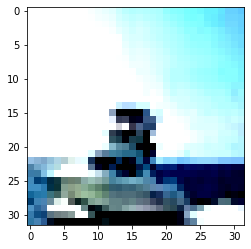

In [ ]:
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

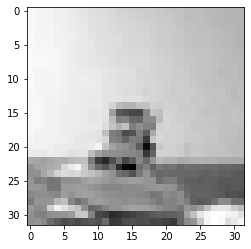

In [ ]:
plt.imshow(img.mean(0), cmap='gray')
plt.show()

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cuda.


In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()
def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <1>
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

In [ ]:
class Bottleneck(nn.Module):
    """
    Bottleneckを使用したresidual blockクラス
    """
    def __init__(self, indim, outdim, is_first_resblock=False):
        super(Bottleneck, self).__init__()
        self.is_dim_changed = (indim != outdim)
        # W, Hを小さくしてCを増やす際はstrideを2にする +
        # projection shortcutを使う様にセット
        if self.is_dim_changed:
            if is_first_resblock:
                # 最初のresblockは(W､ H)は変更しないのでstrideは1にする
                stride = 1
            else:
                stride = 2
            self.shortcut = nn.Conv2d(indim, outdim, 1, stride=stride)
        else:
            stride = 1
        
        dim_inter = int(outdim / 4)
        self.conv1 = nn.Conv2d(indim, dim_inter , 1)
        self.bn1 = nn.BatchNorm2d(dim_inter)
        self.conv2 = nn.Conv2d(dim_inter, dim_inter, 3,
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(dim_inter)
        self.conv3 = nn.Conv2d(dim_inter, outdim, 1)
        self.bn3 = nn.BatchNorm2d(outdim)
        self.relu = nn.ReLU(inplace=True)
        

    def forward(self, x):
        shortcut = x
  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        
        # Projection shortcutの場合
        if self.is_dim_changed:
            shortcut = self.shortcut(x)

        out += shortcut
        out = self.relu(out)

        return out

In [ ]:
#class Cardinality(nn.Module):
    """
    ResNextのCardinality blockクラス
    """


In [ ]:
class ResNet50(nn.Module):
    
    def __init__(self): 
          
        super(ResNet50, self).__init__()
        
        # Due to memory limitation, images will be resized on-the-fly.
        self.upsampler = nn.Upsample(size=(224, 224))

        # Prior block
        self.layer_1 = nn.Conv2d(3, 64, 7, padding=3, stride=2)
        self.bn_1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Residual blocks
        self.resblock1 = Bottleneck(64, 256, True)
        self.resblock2 = Bottleneck(256, 256)
        self.resblock3 = Bottleneck(256, 256)
        self.resblock4 = Bottleneck(256, 512)
        self.resblock5 = Bottleneck(512, 512)
        self.resblock6 = Bottleneck(512, 512)
        self.resblock7 = Bottleneck(512, 512)
        self.resblock8 = Bottleneck(512, 1024)
        self.resblock9 = Bottleneck(1024, 1024)
        self.resblock10 =Bottleneck(1024, 1024)
        self.resblock11 =Bottleneck(1024, 1024)
        self.resblock12 =Bottleneck(1024, 1024)
        self.resblock13 =Bottleneck(1024, 1024)
        self.resblock14 =Bottleneck(1024, 2048)
        self.resblock15 =Bottleneck(2048, 2048)
        self.resblock16 =Bottleneck(2048, 2048)
        
        # Postreior Block
        self.glob_avg_pool = nn.AdaptiveAvgPool2d((1, 1))        
        self.fc = nn.Linear(2048, 10)

    def forward(self, x):
        x = self.upsampler(x)
        
        # Prior block
        x = self.relu(self.bn_1(self.layer_1(x)))
        x = self.pool(x)
        
        # Residual blocks
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.resblock5(x)
        x = self.resblock6(x)
        x = self.resblock7(x)
        x = self.resblock8(x)
        x = self.resblock9(x)
        x = self.resblock10(x)
        x = self.resblock11(x)
        x = self.resblock12(x)
        x = self.resblock13(x)
        x = self.resblock14(x)
        x = self.resblock15(x)
        x = self.resblock16(x)
        
        # Postreior Block
        x = self.glob_avg_pool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1>
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
#model = NetResDeep(n_chans1=32, n_blocks=100).to(device=device)
model = ResNet50().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


2021-08-17 03:36:31.620053 Epoch 1, Training loss 0.7597967270453265
2021-08-17 03:51:09.161113 Epoch 10, Training loss 0.31441902317059267
2021-08-17 04:07:25.961959 Epoch 20, Training loss 0.20726110591630267
2021-08-17 04:23:43.439227 Epoch 30, Training loss 0.09485183538169048
2021-08-17 04:40:00.549764 Epoch 40, Training loss 0.044357189359914534
2021-08-17 04:56:18.188778 Epoch 50, Training loss 0.02324793105785569
2021-08-17 05:12:36.382672 Epoch 60, Training loss 0.020025534794078606
2021-08-17 05:28:54.342425 Epoch 70, Training loss 0.057654607943911695
2021-08-17 05:45:12.262140 Epoch 80, Training loss 0.0036271972700198636
2021-08-17 06:01:29.817471 Epoch 90, Training loss 0.011221607771363246
2021-08-17 06:17:46.638484 Epoch 100, Training loss 0.002524048635955962
Accuracy train: 1.00
Accuracy val: 0.91


In [ ]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list) #, numel_list

23547402

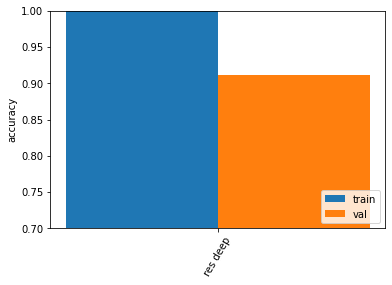

In [ ]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()


In [ ]:
pwd

'/content/gdrive/My Drive/MPS/ResNet'

In [ ]:
trainedModel_path = '../trainedModel/ResNet/'
torch.save(model.state_dict(), trainedModel_path + 'ResNet50.pt')